In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from global_land_mask import globe
import scipy.stats as stats

In [2]:
# Load datasets
dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02CRI.nc")
# catalog = pd.read_csv('eq_200204_202102.csv')
# catalog["time"] = catalog["time"].astype("datetime64")
catalog = pd.read_csv(dataset_path + 'ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64")

In [3]:
def get_mass(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["lwe_thickness"]
    return mass_change.data
  
catalog['dmass'] = catalog.apply(lambda row: get_mass(row), axis=1)

In [4]:
ds

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, time: 194, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-02-15
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2021-03-30T09:03:16Z

In [5]:
catalog['on_land'] = globe.is_land(catalog.latitude, catalog.longitude)

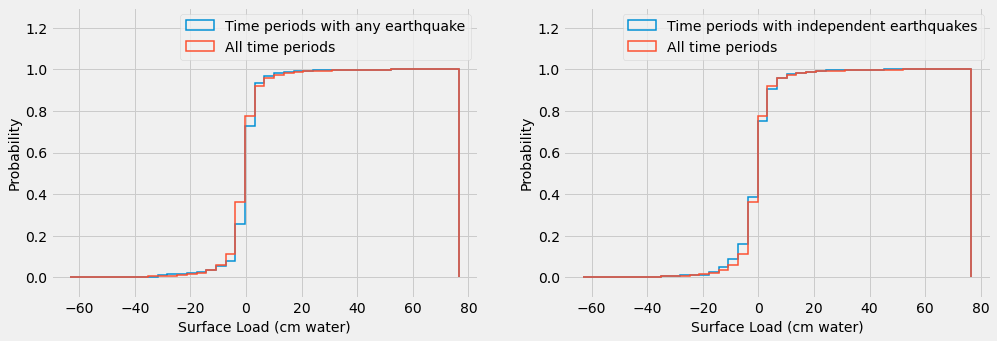

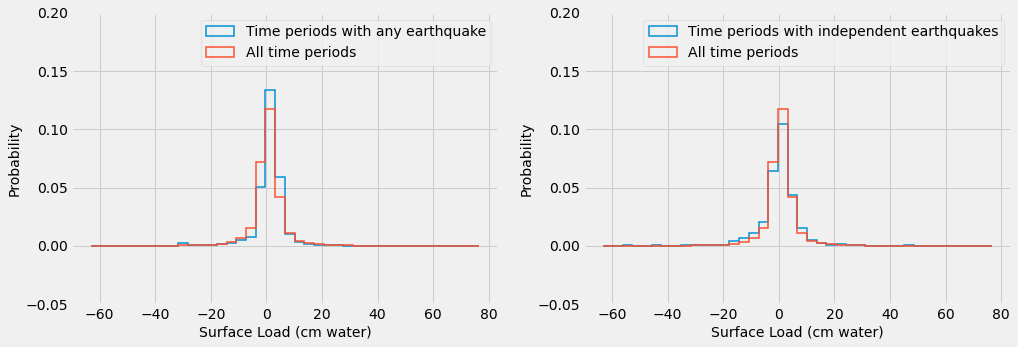

In [61]:
# Plot the distributions
plt.style.use('fivethirtyeight')
bins = np.histogram(catalog['dmass'], 40)[1]
fig,ax = plt.subplots(1, 2, figsize=(15,5))
ax = plt.subplot(1,2,1)
ax.hist(np.array(catalog['dmass']), bins, density = True, cumulative=True, histtype='step',
            label='Time periods with any earthquake',linewidth=1.5)
ax.hist(ds['lwe_thickness'].data.flatten(), bins, density = True, cumulative=True,histtype='step',
            label='All time periods',linewidth=1.5)
plt.xlabel('Surface Load (cm water)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
# ax.set_ylim((1e-5,5))
ax.set_ylim((-0.1,1.3))
# ax.set_yscale('log')
ax.legend()

ax = plt.subplot(1,2,2)
ax.hist(catalog[catalog['P_triggered'] < 0.9]['dmass'], bins, cumulative=True, histtype='step',
        density = True, label='Time periods with independent earthquakes',linewidth=1.5)
ax.hist(ds['lwe_thickness'].data.flatten(), bins, density = True, cumulative=True,histtype='step',
             label='All time periods',linewidth=1.5)
# plt.xlim((-100,100))
ax.set_ylim((-0.1,1.3))
# ax.set_yscale('log')
plt.xlabel('Surface Load (cm water)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
ax.legend()
plt.show()




bins = np.histogram(catalog['dmass'], 40)[1]
fig,ax = plt.subplots(1, 2, figsize=(15,5))
ax = plt.subplot(1,2,1)
ax.hist(np.array(catalog['dmass']), bins, density = True, cumulative=False, histtype='step',
            label='Time periods with any earthquake',linewidth=1.5)
ax.hist(ds['lwe_thickness'].data.flatten(), bins, density = True, cumulative=False,histtype='step',
            label='All time periods',linewidth=1.5)
plt.xlabel('Surface Load (cm water)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
# ax.set_ylim((1e-5,5))
ax.set_ylim((-0.05,0.2))
# ax.set_yscale('log')
ax.legend()

ax = plt.subplot(1,2,2)
ax.hist(catalog[catalog['P_triggered'] < 0.9]['dmass'], bins, cumulative=False, histtype='step',
        density = True, label='Time periods with independent earthquakes',linewidth=1.5)
ax.hist(ds['lwe_thickness'].data.flatten(), bins, density = True, cumulative=False,histtype='step',
             label='All time periods',linewidth=1.5)
# plt.xlim((-100,100))
ax.set_ylim((-0.05,0.2))
# ax.set_yscale('log')
plt.xlabel('Surface Load (cm water)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
ax.legend()
plt.show()

In [7]:
# What is the probability that the two results are the same?
# if p-value < significance level, reject that samples are from same distribution


# a = np.array(catalog[catalog['P_triggered'] < 0.9]['dmass'])
# b = np.array(ds['lwe_thickness'].data.flatten())
# stats.ks_2samp(a,b, mode='asymp')
# output: KstestResult(statistic=0.04963563191122192, pvalue=0.1566585634353047)

# a = np.array(catalog.dmass)
# b =  np.array(ds['lwe_thickness'].data.flatten())
# stats.ks_2samp(, d, mode='asymp')
# output: KstestResult(statistic=0.12212035878155786, pvalue=2.4886704147936648e-123)

In [8]:
a = np.array(catalog.dmass)
b =  np.array(ds['lwe_thickness'].data.flatten())
stats.cramervonmises_2samp(a, b, method='auto')

CramerVonMisesResult(statistic=60.854618746814594, pvalue=9.69405278272717e-09)

In [9]:
a = np.array(catalog[catalog['P_triggered'] < 0.9]['dmass'])
b =  np.array(ds['lwe_thickness'].data.flatten())
stats.cramervonmises_2samp(a, b, method='auto')

CramerVonMisesResult(statistic=18.54565601407802, pvalue=3.6608838183127546e-09)

In [10]:
np.median(catalog[catalog['P_triggered'] < 0.9]['dmass'])

0.6096533443654473

In [11]:
np.median(ds['lwe_thickness'].data.flatten())

0.6627782418257632

In [12]:
np.median(np.array(catalog.dmass))

1.425528633547053

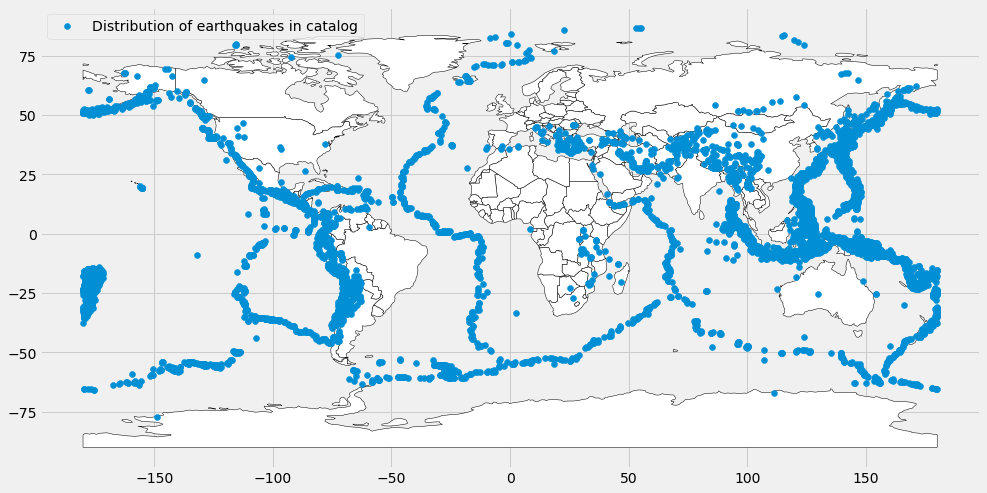

In [15]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(catalog.longitude, catalog.latitude))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = world.plot(color='white', edgecolor='black', figsize=(8,6))
ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
gdf.plot(ax=ax, label='Distribution of earthquakes in catalog')
leg = ax.legend()

# gdi = gpd.GeoDataFrame(df_ind, geometry=gpd.points_from_xy(df_ind.longitude, df_ind.latitude))
# gdi.plot(ax=ax, markersize = 5)

# plt.show()

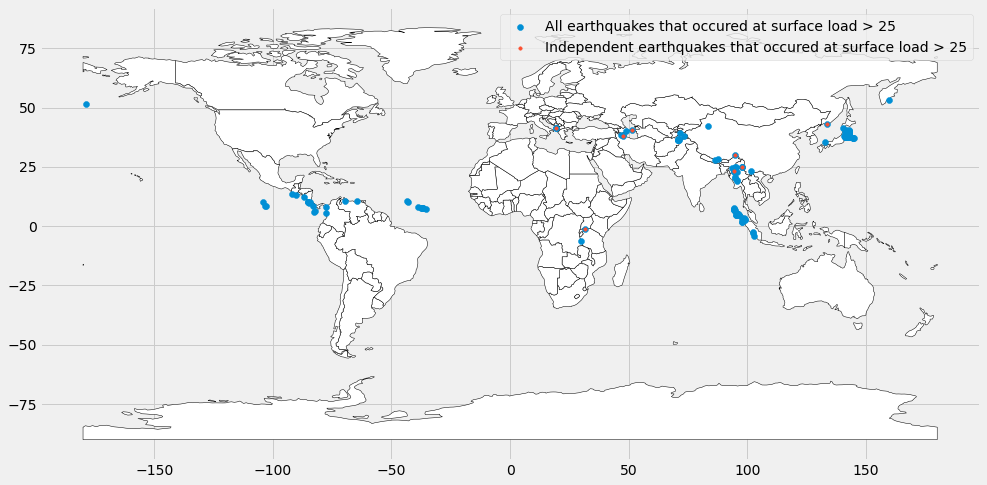

In [16]:
thr = 25
df_bigmass = catalog[np.abs(catalog['dmass']) > thr]
gdf = gpd.GeoDataFrame(df_bigmass,
                       geometry=gpd.points_from_xy(df_bigmass.longitude, 
                                                   df_bigmass.latitude))

df_bigmass_ind = catalog[(np.abs(catalog['dmass']) > thr) & (catalog['P_triggered'] < 0.9)]
gdi = gpd.GeoDataFrame(df_bigmass_ind,
                       geometry=gpd.points_from_xy(df_bigmass_ind.longitude, 
                                                   df_bigmass_ind.latitude))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
gdf.plot(ax=ax, label='All earthquakes that occured at surface load > 25')
gdi.plot(ax=ax, markersize = 12, label = 'Independent earthquakes that occured at surface load > 25')
leg = ax.legend()
plt.show()

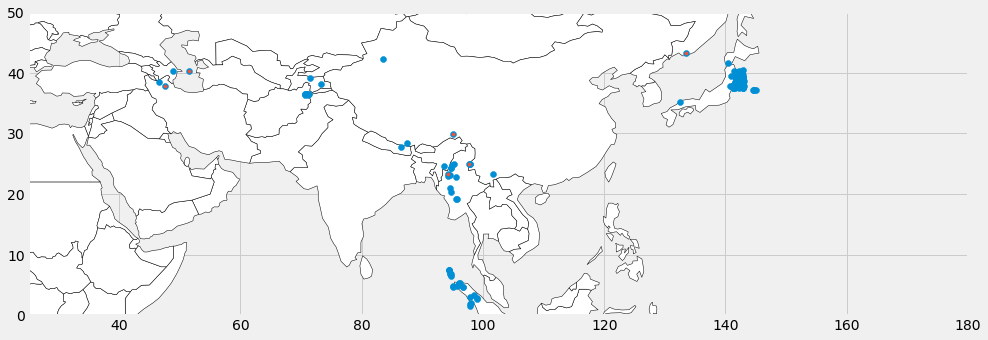

In [17]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = world.plot(color='white', edgecolor='black', figsize=(8,6))
ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
gdf.plot(ax=ax)
gdi.plot(ax=ax, markersize = 10)
ax.set_xlim((25,180))
ax.set_ylim((0,50))
plt.show()

In [18]:
catalog

,target_id,latitude,longitude,time,magnitude,geometry,mu,P_triggered,P_background,dmass,on_land
0,4,-17.8133,167.6409,2021-02-16 01:32:00.512,5.9,POINT (-17.8133 167.6409),8.774521e-11,1.000000,2.121062e-07,2.0916352647315017,False
1,5,-17.6418,167.7070,2021-02-16 01:22:19.487,5.5,POINT (-17.6418 167.707),8.774521e-11,0.999999,1.246521e-06,2.0916352647315017,False
2,6,-17.8292,167.5413,2021-02-16 00:49:25.141,6.2,POINT (-17.8292 167.5413),8.774521e-11,0.999291,7.086025e-04,2.0916352647315017,False
3,7,37.5475,141.3336,2021-02-15 12:26:17.164,5.4,POINT (37.5475 141.3336),8.774521e-11,0.999965,3.464217e-05,11.703077510294515,False
4,8,1.0418,-85.2104,2021-02-14 19:46:53.007,5.4,POINT (1.0418 -85.21040000000001),8.774521e-11,0.999399,6.008943e-04,1.9580783657750576,False
...,...,...,...,...,...,...,...,...,...,...,...
9451,9455,-54.1600,-135.7460,2006-01-24 04:27:08.360,5.5,POINT (-54.16 -135.746),8.774521e-11,0.999215,7.845676e-04,-1.3449255140992764,False
9452,9456,6.8470,-77.9740,2006-01-23 20:52:30.250,5.5,POINT (6.847 -77.97399999999998),8.774521e-11,1.000000,8.815987e-08,-10.228942444509205,False
9453,9457,6.8640,-77.7930,2006-01-23 20:50:44.980,6.2,POINT (6.864 -77.79300000000001),8.774521e-11,0.921730,7.827037e-02,-10.228942444509205,False
9454,9458,-25.3260,178.3160,2006-01-23 13:16:34.590,5.6,POINT (-25.326 178.316),8.774521e-11,0.990831,9.169180e-03,-3.3405780315289526,False


In [19]:
catalog['dmass']

0        2.0916352647315017
1        2.0916352647315017
2        2.0916352647315017
3        11.703077510294515
4        1.9580783657750576
               ...         
9451    -1.3449255140992764
9452    -10.228942444509205
9453    -10.228942444509205
9454    -3.3405780315289526
9455     -3.518111548222055
Name: dmass, Length: 9456, dtype: object

In [20]:
len(ds['lwe_thickness'])

194

## Correlation between reconstructed D values and seismic activity


In [29]:
# Loading D values from pca grace

D_eq_values = np.loadtxt('D_eq_values.csv', delimiter=',')

D_eq_values

array([ 4.25953655,  4.25953655,  4.25953655, ..., -0.89574501,
       -0.21415966, -0.29122169])

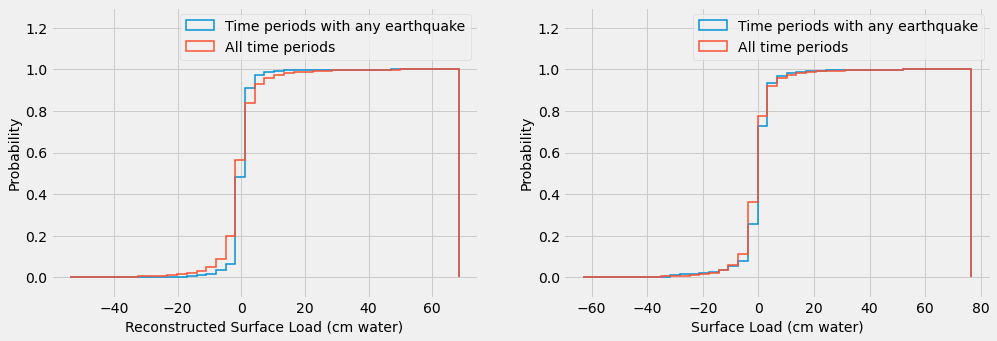

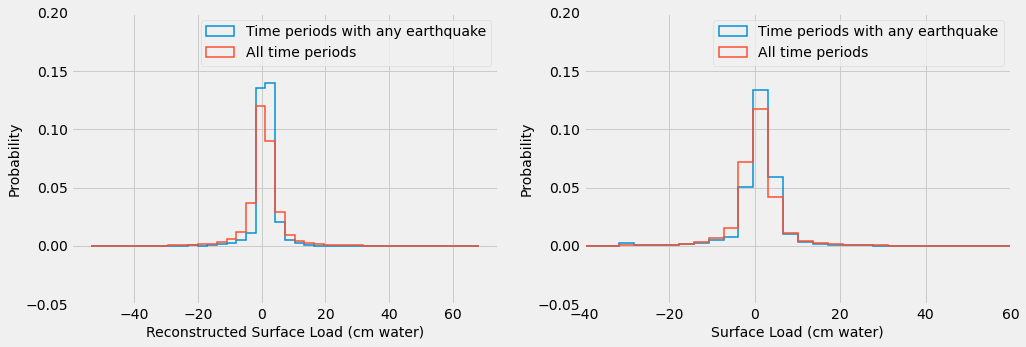

In [70]:
# Plot the distributions using reconstructed D values

plt.style.use('fivethirtyeight')
bins = np.histogram(D_eq_values, 40)[1]
fig,ax = plt.subplots(figsize=(15,5))
ax = plt.subplot(1,2,1)
ax.hist(D_eq_values, bins, density = True, cumulative=True, histtype='step',
            label='Time periods with any earthquake',linewidth=1.5)
ax.hist(ds['lwe_thickness'].data.flatten(), bins, density = True, cumulative=True,histtype='step',
            label='All time periods',linewidth=1.5)
plt.xlabel('Surface Load Reconstructed with first PC (cm water)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
# ax.set_ylim((1e-5,5))
ax.set_ylim((-0.1,1.3))
# ax.set_yscale('log')
ax.legend()

bins = np.histogram(catalog['dmass'], 40)[1]
ax = plt.subplot(1,2,2)
ax.hist(np.array(catalog['dmass']), bins, density = True, cumulative=True, histtype='step',
            label='Time periods with any earthquake',linewidth=1.5)
ax.hist(ds['lwe_thickness'].data.flatten(), bins, density = True, cumulative=True,histtype='step',
            label='All time periods',linewidth=1.5)
plt.xlabel('Surface Load (cm water)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
# ax.set_ylim((1e-5,5))
ax.set_ylim((-0.1,1.3))
# ax.set_yscale('log')
ax.legend()


bins = np.histogram(D_eq_values, 40)[1]
fig,ax = plt.subplots(1, 2, figsize=(15,5))
ax = plt.subplot(1,2,1)
ax.hist(D_eq_values, bins, density = True, cumulative=False, histtype='step',
            label='Time periods with any earthquake',linewidth=1.5)
ax.hist(ds['lwe_thickness'].data.flatten(), bins, density = True, cumulative=False,histtype='step',
            label='All time periods',linewidth=1.5)
plt.xlabel('Surface Load Reconstructed with first PC (cm water)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
# ax.set_ylim((1e-5,5))
ax.set_ylim((-0.05,0.2))
# ax.set_yscale('log')
ax.legend()

bins = np.histogram(catalog['dmass'], 40)[1]
ax = plt.subplot(1,2,2)
ax.hist(np.array(catalog['dmass']), bins, density = True, cumulative=False, histtype='step',
            label='Time periods with any earthquake',linewidth=1.5)
ax.hist(ds['lwe_thickness'].data.flatten(), bins, density = True, cumulative=False,histtype='step',
            label='All time periods',linewidth=1.5)
plt.xlabel('Surface Load (cm water)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
# ax.set_ylim((1e-5,5))
ax.set_ylim((-0.05,0.2))
ax.set_xlim((-40,60))
# ax.set_yscale('log')
ax.legend()

In [54]:
a = D_eq_values
b =  np.array(ds['lwe_thickness'].data.flatten())
stats.cramervonmises_2samp(a, b, method='auto')

CramerVonMisesResult(statistic=140.12630109579368, pvalue=5.173378503364745e-08)

In [55]:
a = np.array(catalog.dmass)
b =  np.array(ds['lwe_thickness'].data.flatten())
stats.cramervonmises_2samp(a, b, method='auto')

CramerVonMisesResult(statistic=60.854618746814594, pvalue=9.69405278272717e-09)

In [66]:
# Loading D2 values from pca grace

D2_eq_values = np.loadtxt('D2_eq_values.csv', delimiter=',')

D2_eq_values

array([-0.73832857, -0.73832857, -0.73832857, ..., -0.76029373,
       -0.19774716, -0.19153626])

In [67]:
a = D2_eq_values
b =  np.array(ds['lwe_thickness'].data.flatten())
stats.cramervonmises_2samp(a, b, method='auto')

CramerVonMisesResult(statistic=332.7706093706174, pvalue=1.002088233503784e-07)

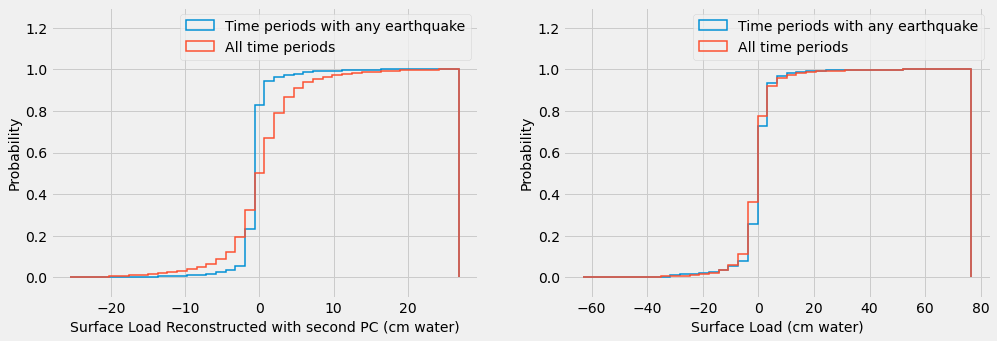

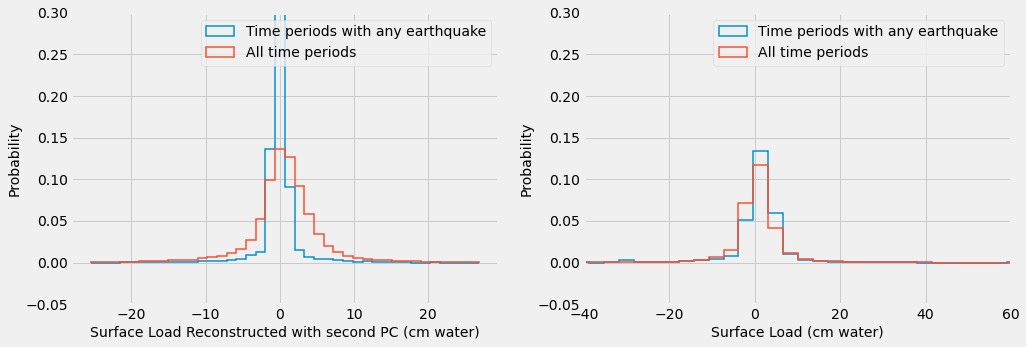

In [72]:
plt.style.use('fivethirtyeight')
bins = np.histogram(D2_eq_values, 40)[1]
fig,ax = plt.subplots(figsize=(15,5))
ax = plt.subplot(1,2,1)
ax.hist(D2_eq_values, bins, density = True, cumulative=True, histtype='step',
            label='Time periods with any earthquake',linewidth=1.5)
ax.hist(ds['lwe_thickness'].data.flatten(), bins, density = True, cumulative=True,histtype='step',
            label='All time periods',linewidth=1.5)
plt.xlabel('Surface Load Reconstructed with second PC (cm water)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
# ax.set_ylim((1e-5,5))
ax.set_ylim((-0.1,1.3))
# ax.set_yscale('log')
ax.legend()

bins = np.histogram(catalog['dmass'], 40)[1]
ax = plt.subplot(1,2,2)
ax.hist(np.array(catalog['dmass']), bins, density = True, cumulative=True, histtype='step',
            label='Time periods with any earthquake',linewidth=1.5)
ax.hist(ds['lwe_thickness'].data.flatten(), bins, density = True, cumulative=True,histtype='step',
            label='All time periods',linewidth=1.5)
plt.xlabel('Surface Load (cm water)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
# ax.set_ylim((1e-5,5))
ax.set_ylim((-0.1,1.3))
# ax.set_yscale('log')
ax.legend()


bins = np.histogram(D2_eq_values, 40)[1]
fig,ax = plt.subplots(1, 2, figsize=(15,5))
ax = plt.subplot(1,2,1)
ax.hist(D2_eq_values, bins, density = True, cumulative=False, histtype='step',
            label='Time periods with any earthquake',linewidth=1.5)
ax.hist(ds['lwe_thickness'].data.flatten(), bins, density = True, cumulative=False,histtype='step',
            label='All time periods',linewidth=1.5)
plt.xlabel('Surface Load Reconstructed with second PC (cm water)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
# ax.set_ylim((1e-5,5))
ax.set_ylim((-0.05,0.3))
# ax.set_yscale('log')
ax.legend()

bins = np.histogram(catalog['dmass'], 40)[1]
ax = plt.subplot(1,2,2)
ax.hist(np.array(catalog['dmass']), bins, density = True, cumulative=False, histtype='step',
            label='Time periods with any earthquake',linewidth=1.5)
ax.hist(ds['lwe_thickness'].data.flatten(), bins, density = True, cumulative=False,histtype='step',
            label='All time periods',linewidth=1.5)
plt.xlabel('Surface Load (cm water)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
# ax.set_ylim((1e-5,5))
ax.set_ylim((-0.05,0.3))
ax.set_xlim((-40,60))
# ax.set_yscale('log')
ax.legend()